# Régression linéaire avec Pytorch

Dans ce notebook, nous allons apprendre à utiliser Pytorch pour entraîner un modèle de régression linéaire sur le jeu de données Boston de Scikit-learn.

L'objectif est de prédire le prix des maisons à partir de leurs caractéristiques.

## Importation des packages

In [ ]:
!pip install scikit-learn==1.1

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchsummary import summary

## Importation des données

In [ ]:
boston = load_boston()
X = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Séparation du jeu d'entraînement et du jeu de test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, boston['target'], test_size=0.33, random_state=42)

Normalisation du jeu de données

In [ ]:
std_scaler = StandardScaler().fit(X_train, y_train)

X_train  =  std_scaler.transform(X_train)
X_test = std_scaler.transform(X_test)

Passage de Numpy à Pytorch

In [ ]:
x_train_torch = torch.from_numpy(X_train).to(torch.float32)
x_test_torch = torch.from_numpy(X_test).to(torch.float32)

y_train_torch = torch.from_numpy(y_train.reshape(-1, 1)).to(torch.float32)
y_test_torch = torch.from_numpy(y_test.reshape(-1, 1)).to(torch.float32)

## Création de l'architecture

La fonction `Linear` permet d'initialiser les poids pour la régression linéaire et d'effectuer une multiplication matricielle entre les poids et les exemples d'entraînement. Utilisez les paramètres `in_features` et `out_features` pour spécifier le nombre d'entrées et de sorties de la couche.

Pour plus d'informatons, n'hésitez pas à lire la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

La fonction `Linear` sera déclarée dans un modèle via la fonction `Sequential`.

Pour plus d'informatons, n'hésitez pas à lire la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).


In [ ]:
def linear_regression(input_shape:int, output_shape:int)->torch.nn.Sequential:
  """
  Creates a simple linear regression model in PyTorch.

  This function initializes a linear regression model with a single linear layer.
  The linear layer applies an affine transformation to the input data, mapping
  from an input space of dimension `input_shape` to an output space of dimension `output_shape`.

  Args:
      input_shape (int): Number of input features (size of the input layer).
      output_shape (int): Number of desired outputs (size of the output layer).

  Returns:
      torch.nn.Sequential: A PyTorch model containing the specified linear layer.
  """
  model = torch.nn.Sequential(torch.nn.Linear(in_features=input_shape, out_features=output_shape))
  return model

Initialiser notre modèle en utilisant la fonction précédente `linear_regression`

In [ ]:
rl_model = linear_regression(input_shape=13, output_shape=1)

Utilisez la fonction `print` pour visualiser l'architecture du modèle.

In [ ]:
print(rl_model)

Sequential(
  (0): Linear(in_features=13, out_features=1, bias=True)
)


Utilisez la fonction `summary` pour obtenir une visualisation de meilleur qualité.

Aidez-vous de la [doc](https://pypi.org/project/torch-summary/)

In [ ]:
summary(rl_model, (13,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]              14
Total params: 14
Trainable params: 14
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Prédire notre jeu d'entraînement.

Utilisez la méthode `forward` du modèle `rl_model` sur les données `x_train_torch` pour appliquer le modèle sur les données.

In [ ]:
prediction = rl_model.forward(x_train_torch)

## Définir la fonction de coût

Vous allez maintenant initialiser votre fonction de coût.

Pour ce notebook utilisez la mean absolute error qui a pour nom `L1Loss` en Pytorch.

N'hésitez pas à lire la [documentation](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html).

In [ ]:
criterion = torch.nn.L1Loss()

Appliquez la fonction de coût du nom de `criterion` pour comparer les données prédites par notre modèle `prediction` et les valeurs exactes `y_train_torch`.

In [ ]:
loss = criterion(prediction, y_train_torch)

### Calculer les gradients

Vous allez calculer les gradients par rapport à l’erreur pour mettre à jour les poids du modèle.

L’objectif est d’ajuster les poids afin de faire converger l’erreur vers 0.

La fonction `backward` de PyTorch permet de calculer automatiquement les gradients qu'importe le graph de calcul que vous avez créé.

Imaginons une matrice de paramètres *w_1* qui va être multiplier par les données *x_1*.

On spécifie bien `requires_grad=True` pour les paramètres.

In [ ]:
w_1 = torch.randn([2, 1], dtype=float, requires_grad=True)
x_1 = torch.randn([5, 2], dtype=float)
y = torch.randn([5, 1], dtype=float)

h = torch.mm(x_1, w_1)
print(h.shape)

torch.Size([5, 1])


Calculons l'erreur de prédiction qui est l'écart entre *y* et *h*.

In [ ]:
error = torch.mean(h-y)
print(error)

tensor(-0.9974, dtype=torch.float64, grad_fn=<MeanBackward0>)


On va maintenant calculer les gradients des poids *w_1*

In [ ]:
print(w_1.grad)
error.backward()
print(w_1.grad)

None
tensor([[0.8467],
        [0.1626]], dtype=torch.float64)


On peut voir que les gradients on été initiliasé à *None*, c'est seulement après l'utilisation de la fonction `backward` que les gradients sont calculés.

Regardons ce que ça donne pour le modèle `rl_model`.

In [ ]:
loss

tensor(23.1111, grad_fn=<MeanBackward0>)

On peut voir que la loss caculée précédemment garde des informations sur la fonction de coût et les gradients.

In [ ]:
print(rl_model[0].weight.grad)

None


Pour le moment le modèle ne contient aucun gradient.

Utilisez la méthode `backward` du coût `loss` pour calculer les gradients du modèle `rl_model`.

In [ ]:
loss.backward()

Observez les gradients ainsi obtenus.

In [ ]:
print(rl_model[0].weight.grad)

tensor([[-2.1741e-09, -9.9730e-09,  1.6473e-08,  5.4041e-08, -4.6117e-09,
         -7.3844e-09,  1.4788e-08,  5.2371e-09,  1.3034e-09, -1.4871e-08,
          6.5814e-11,  1.3390e-08,  7.9276e-09]])


### Optimiser les paramètres du modèle

Maintenant que vous avez calculé vos gradients il va falloir mettre à jour les paramètres du modèle.

Il existe de nombreux algorithmes d'optimisation, ici on va rester simple en utilisant celui du Stochastic Gradient Descent `SGD`.

Vous allez d'abord initialiser l'algorithme d'optimisation avec la fonction `SGD` en paramètre il faudra lui donner les paramètres du modèle `rl_model` avec la méthode `parameters` et un learning rate `lr` de 0.3.

N'hésitez pas à regarder la [documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [ ]:
optimizer = torch.optim.SGD(rl_model.parameters(), lr=1)

Regardez les valeurs des paramètres du modèle.

In [ ]:
print(rl_model[0].weight)

Parameter containing:
tensor([[ 0.0691, -0.2716,  0.1170,  0.1510,  0.0740,  0.1648,  0.0294,  0.1783,
          0.2528, -0.1496, -0.1378,  0.0181,  0.2523]], requires_grad=True)


Regardez les gradients de chaque paramètre.

In [ ]:
print(rl_model[0].weight.grad)

tensor([[-2.1741e-09, -9.9730e-09,  1.6473e-08,  5.4041e-08, -4.6117e-09,
         -7.3844e-09,  1.4788e-08,  5.2371e-09,  1.3034e-09, -1.4871e-08,
          6.5814e-11,  1.3390e-08,  7.9276e-09]])


Calculez le coût du modèle à ce stade.

In [ ]:
loss

tensor(23.1111, grad_fn=<MeanBackward0>)

Utilisez la méthode `step` de l'algorithme d'optimisation `optimizer` afin de mettre à jour les paramètres du modèle en utilisant l'algorithme du gradient descent en utilisant les gradients précédemment calculé.

In [ ]:
optimizer.step()

Regardez les nouvelles valeurs des paramètres du modèle.

In [ ]:
print(rl_model[0].weight)

Parameter containing:
tensor([[ 0.0691, -0.2716,  0.1170,  0.1510,  0.0740,  0.1648,  0.0294,  0.1783,
          0.2528, -0.1496, -0.1378,  0.0181,  0.2523]], requires_grad=True)


Utilisez la méthode `forward` pour prédire les données avec les nouveaux paramètres du modèle.

In [ ]:
prediction = rl_model.forward(x_train_torch)

Utilisez `criterion` pour calculer le coût du modèle avec les nouveaux paramètres.

In [ ]:
criterion(prediction, y_train_torch)

tensor(22.1111, grad_fn=<MeanBackward0>)

On observe qu'avec les nouveaux paramètres, le coût est inférieur au précédent.

Le modèle converge donc vers un ensemble de paramètres qui minimise l'erreur de prédiction.

## Définir la fonction d'entraînement

Vous allez maintenant initialiser la fonction d'entraînement du modèle en utilisant le modèle, la fonction de coût et l'algorithme d'optimisation précédemment initialisé.

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  optimizer.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  optimizer.step()

  return model, loss

## Entraîner le modèle

Il est maintenant temps d'entraîner le modèle



In [ ]:
epoch = 1000
history_train = []
history_test = []

for e in range(epoch) :

  # mise à jour des poids avec la fonction 'step'
  rl_model, train_loss = step(rl_model, optimizer, criterion, x_train_torch, y_train_torch)

  # prédiction sur le jeu de test avec la méthode 'foward'
  test_pred = rl_model.foward(x_test_torch)

  # Calculer l'erreur de prédiction sur le jeu de test avec 'criterion'
  test_loss = criterion(test_pred, y_test_torch)

  # Sauvegarde des coûts d'entraînement de l'entraînement et du jeu de test avec append
  history_train = np.append(history_train, train_loss.detach().numpy())
  history_test = np.append(history_test, test_loss.detach().numpy())

  print('train_loss : '+str(np.squeeze(train_loss.detach().numpy()))+ ' test_loss : '+str(test_loss.detach().numpy()))


train_loss : 22.111115 test_loss : 19.823816
train_loss : 21.111115 test_loss : 18.823814
train_loss : 20.111115 test_loss : 17.823812
train_loss : 19.111115 test_loss : 16.844242
train_loss : 18.111752 test_loss : 15.872369
train_loss : 17.123892 test_loss : 14.909666
train_loss : 16.146116 test_loss : 13.959963
train_loss : 15.188881 test_loss : 13.022208
train_loss : 14.237377 test_loss : 12.086484
train_loss : 13.285989 test_loss : 11.158049
train_loss : 12.340439 test_loss : 10.238702
train_loss : 11.396539 test_loss : 9.319356
train_loss : 10.457681 test_loss : 8.403418
train_loss : 9.526787 test_loss : 7.5047894
train_loss : 8.611082 test_loss : 6.6618695
train_loss : 7.7663536 test_loss : 5.954105
train_loss : 6.9928327 test_loss : 5.3111453
train_loss : 6.2844505 test_loss : 4.7740393
train_loss : 5.667228 test_loss : 4.329431
train_loss : 5.1213894 test_loss : 3.9980145
train_loss : 4.671545 test_loss : 3.7961013
train_loss : 4.340914 test_loss : 3.6117272
train_loss : 4.0832

Visualisation de l'évolution du coût pendant l'entraînement.

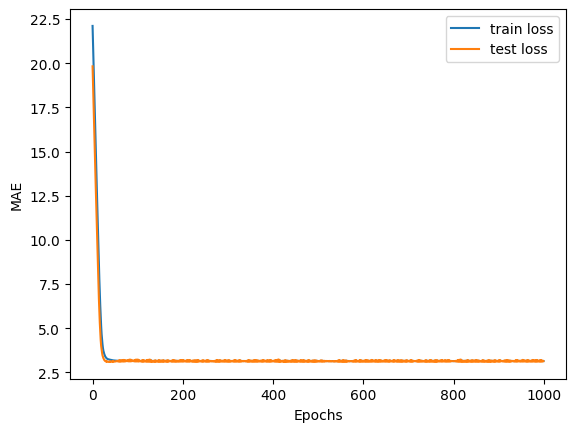

In [ ]:
plt.plot(np.arange(epoch), history_train, label='train loss')
plt.plot(np.arange(epoch), history_test, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Sauvegarde du modèle

Maintenant que le modèle est entraîné, il est temps de le sauvegarder.

Sauvegardez les poids du modèle grâce à la méthode `save`.

N'hésitez pas à vous aider de la [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
torch.save(rl_model.state_dict(), 'linear_regression.pth')

Remplacez le modèle entraîné par un nouveau modèle dont les poids sont initialisés aléatoirement.

In [ ]:
rl_model = linear_regression(input_shape=13, output_shape=1)

Calculez la performance de ce modèle.

In [ ]:
prediction = rl_model(x_train_torch)
criterion(prediction, y_train_torch)

tensor(23.1336, grad_fn=<MeanBackward0>)

Comme les paramètres du modèle sont initialisés aléatoirement, les performances sont faibles.

Nous pouvons restaurer nos poids entraînés en chargeant les poids précédemment sauvegardés.

En utilisant la méthode `load_state_dict`.

Aidez-vous de la [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
rl_model.load_state_dict(torch.load('linear_regression.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
prediction = rl_model.forward(x_train_torch)
criterion(prediction, y_train_torch)

tensor(3.1398, grad_fn=<MeanBackward0>)

Maintenant que les paramètres du modèle entraîné sont chargés, ses performances sont identiques au précédent modèle.